# Neural Network Classification

In [1]:
# generating data with sklearn

from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create data
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [2]:
# make pandas df

import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y
                       })

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [3]:
# check diversity
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

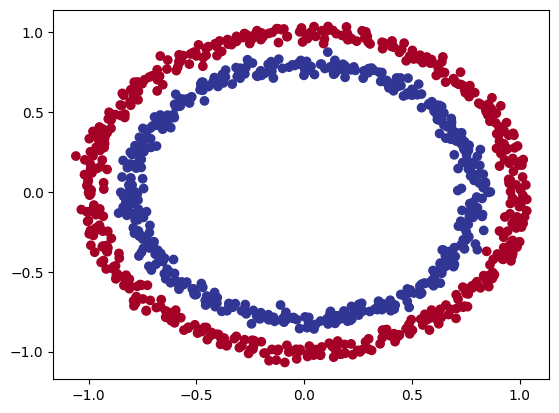

In [4]:
# visualise

import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)
plt.show()

In [5]:
# check shapes of inputs and outputs
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# turn data into torch tensors

import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [8]:
# pytorch imports + device agnostic code

import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
# create model class
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # first layer takes 2 input features
        # output should be number of neurons if hidden layer
        # or number of outputs if last layer
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

# create instance of model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
# # could refactor using nn.Sequential()...
# model_0 = nn.Sequential(
#     nn.Linear(in_features = 2, out_features = 5),
#     nn.Linear(in_features = 5, out_features = 1)
# ).to(device)

# model_0

In [11]:
# make predictions on the untrained model
untrained_preds = model_0(X_test.to(device))
print(untrained_preds[:10])
print(untrained_preds.shape, y_test.shape)

tensor([[0.5632],
        [0.5303],
        [0.4624],
        [0.5925],
        [0.1656],
        [0.1478],
        [0.2905],
        [0.2002],
        [0.4751],
        [0.5248]], grad_fn=<SliceBackward0>)
torch.Size([200, 1]) torch.Size([200])


In [12]:
# note above that the predictions and y_test are of different shape
# we could squeeze the predictions tensor to force it into the same shape
# or we could unsqueeze the y_test tensor

In [13]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss() # this incorporates sigmoid activation
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [14]:
# define accuracy as eval metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
# training and testing loop

torch.manual_seed(42)

# set epochs
epochs = 100

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
    ### training
    model_0.train()

    # forward pass (model will output raw logits)
    y_logits = model_0(X_train).squeeze() # removes extra dimension
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits > pred probs > pred labels

    # calculate loss/accuracy
    loss = loss_fn(y_logits, # BCEWithLogitsLoss will apply sigmoid to these
                   y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)
    
    # zero grads
    optimizer.zero_grad()

    # back prop
    loss.backward()

    # step optimizer
    optimizer.step()

    ### testing
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
        
        # print info
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71323, Accuracy: 50.00% | Test loss: 0.71434, Test acc: 50.00%
Epoch: 10 | Loss: 0.70342, Accuracy: 53.00% | Test loss: 0.70479, Test acc: 51.50%
Epoch: 20 | Loss: 0.69901, Accuracy: 55.75% | Test loss: 0.70037, Test acc: 55.50%
Epoch: 30 | Loss: 0.69681, Accuracy: 52.62% | Test loss: 0.69811, Test acc: 53.00%
Epoch: 40 | Loss: 0.69558, Accuracy: 52.00% | Test loss: 0.69684, Test acc: 53.50%
Epoch: 50 | Loss: 0.69484, Accuracy: 51.25% | Test loss: 0.69605, Test acc: 52.50%
Epoch: 60 | Loss: 0.69434, Accuracy: 51.25% | Test loss: 0.69552, Test acc: 52.00%
Epoch: 70 | Loss: 0.69400, Accuracy: 51.38% | Test loss: 0.69516, Test acc: 52.00%
Epoch: 80 | Loss: 0.69375, Accuracy: 51.25% | Test loss: 0.69489, Test acc: 51.50%
Epoch: 90 | Loss: 0.69357, Accuracy: 51.25% | Test loss: 0.69470, Test acc: 51.00%


In [16]:
# visualise predictions (which are bad)

import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


/Users/sach/pytorch_course/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


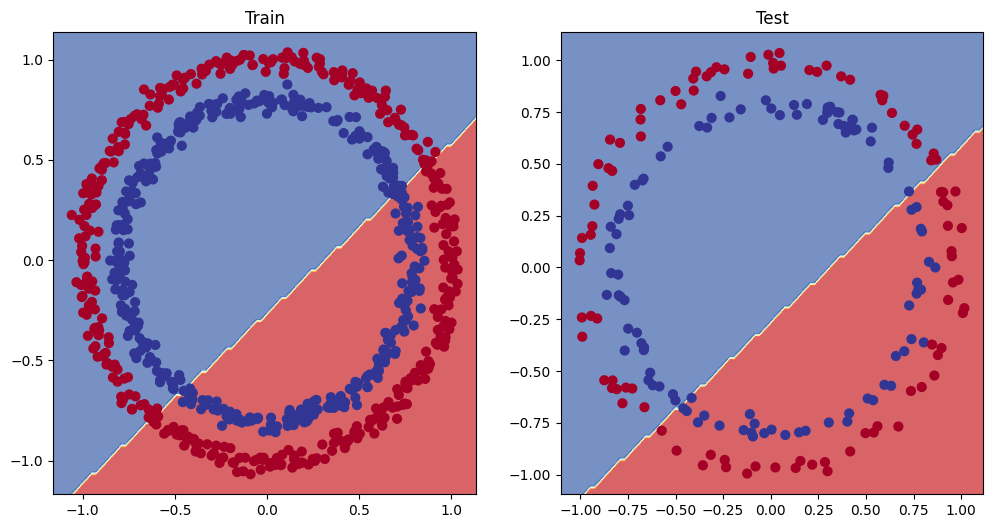

In [17]:
# plot decision boundaries for training and test sets
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [18]:
# clearly model is underfitting
# we are trying to fit polar data to linear model
# ways in which we could improve model

In [19]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [20]:
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [21]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


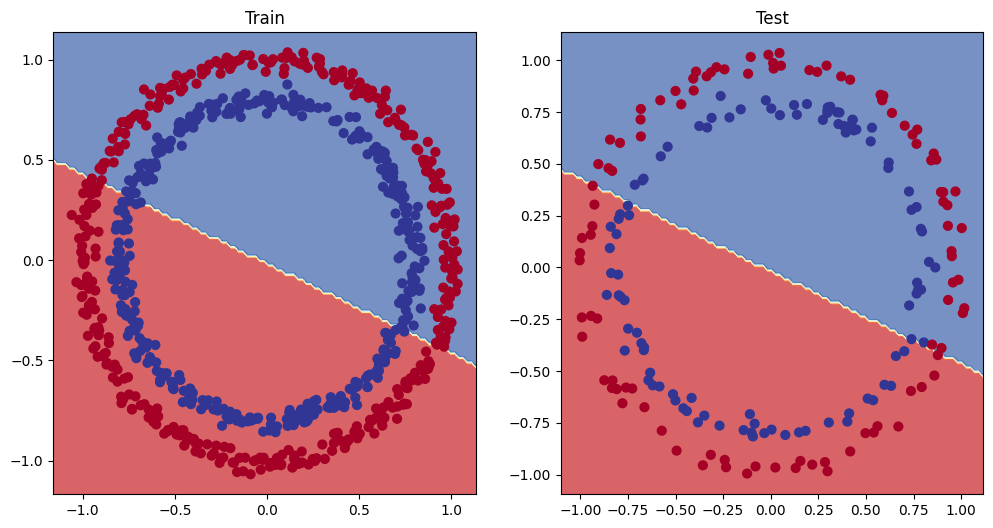

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

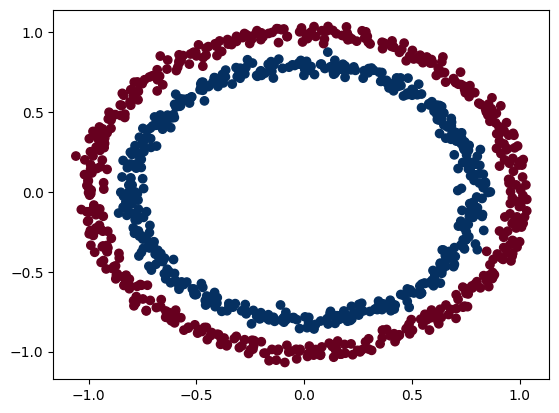

In [23]:
# building a model to deal with non-linearity

n_samples = 1000

X, y = make_circles(n_samples = n_samples,
                    noise = 0.03,
                    random_state = 42)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.RdBu)
plt.show()

In [24]:
# convert to tensors and split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [25]:
# build model with non-linear activation

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # relu interspersed between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
                            
model_3 = CircleModelV2().to(device)
print(model_3)                    

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [26]:
# loss and opt
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [27]:
# fit model
torch.manual_seed(42)
epochs = 1000

# device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### training
    model_3.train()

    # forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)
    
    # zero grads
    optimizer.zero_grad()

    # back prop
    loss.backward()

    # step opt
    optimizer.step()

    ### testing
    model_3.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
        
    # print info
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [28]:
# make preds
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

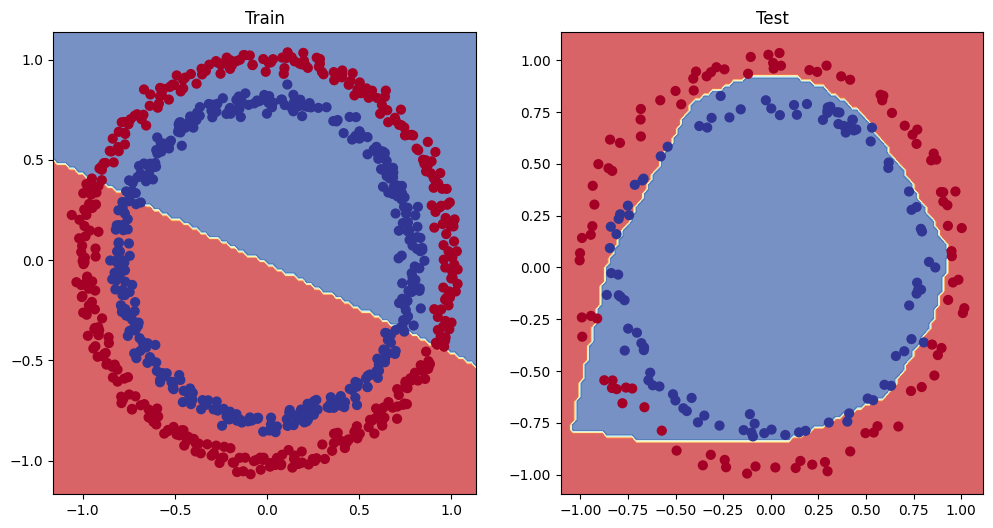

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

In [1]:
# multi-class classification example

from sklearn.datasets import make_blobs

# hyperparams for data creation
N_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create data
X_blob, y_blob = make_blobs(n_samples = N_SAMPLES,
                           n_features = NUM_FEATURES,
                           centers = NUM_CLASSES,
                           cluster_std = 1.5,
                           random_state = RANDOM_SEED)

# turn into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# train test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size = 0.2,
    random_state = RANDOM_SEED
    )

# plot data
# plt.figure(figsize = (10, 7))
# plt.scatter(X_blob[:, 0])

NameError: name 'torch' is not defined